In [1]:
# 使用するライブラリのimport
import os
import numpy as np

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch


In [5]:
# 定数の宣言
#IMAGES_PATH = "images"                                  # 生成画像の出力先フォルダ
#DATA_PATH = "data/mnist"                                # テストデータフォルダ

EPOCHS = 100                                             # エポック数
BATCH_SIZE = 64                                          # バッチサイズ

LEARNING_RATE = 0.6                                      # 学習率

LATENT_DIM = 96                                        # 潜在変数（z)の次元数
#IMG_SIZE = 28                                             # 画像の幅と高さ
#CHANNELS = 1                                             # 画像のチャンネル数（１＝グレー）
#img_shape = (CHANNELS, IMG_SIZE, IMG_SIZE)             # イメージ画像（チャンネル、幅、高さ）

N_CRITIC = 5                                              # Gの学習ステップ（D / iter）
CLIP_VALUE = 0.01                                        # 重みのクリップ範囲
#SAMPLE_INTERVAL = 50                                   # 生成画像サンプリングのタイミング

cuda = True if torch.backends.mps.is_available() else False          # GPUの利用チェック
device = "mps"
print('GPU Check! gpu is ', cuda)


GPU Check! gpu is  True


In [24]:
# Generatorの定義
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(LATENT_DIM, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 264),
            nn.Tanh()
        )   

    def forward(self, z):
        G_z = self.model(z)
        return G_z


In [25]:
# Discriminatorの定義
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(264, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, order_embedding):
        validity = self.model(order_embedding)

        return validity

In [15]:
torch.randn(10000, 264, device=device)

tensor([[ 0.8374, -0.2075,  0.8409,  ..., -0.5431,  0.6250,  0.1151],
        [ 0.4704,  1.0896, -0.9493,  ...,  0.8851, -0.6348,  1.8683],
        [-0.2811,  2.5001, -0.4120,  ..., -1.0521, -0.2279,  2.1911],
        ...,
        [ 0.9669, -1.9711, -0.4081,  ...,  0.6806, -0.7083, -2.0746],
        [-0.3270, -0.8994,  1.0688,  ...,  1.0018,  0.4424, -1.9012],
        [-0.4293, -0.1112,  0.2283,  ..., -0.8890, -0.4113, -0.8154]],
       device='mps:0')

In [26]:
# GeneratorとDiscriminatorのインスタンス化
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.to("mps")
    discriminator.to("mps")

# order_embeddingの作成（ここでは，サイズがあってる擬似的なembeddingとする）
order_embedding = torch.randn(10000, 264, device=device)

dataloader = torch.utils.data.DataLoader(
    order_embedding,
    batch_size = BATCH_SIZE,
    shuffle = True)

for i, order in enumerate(dataloader):
    print(i)
    print(order.shape[0])
    break

0
64


In [27]:
# 最適化関数のセット
optimizer_G = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)

#Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [29]:
import torch
import numpy as np
from torch.autograd import Variable
from torchvision.utils import save_image

# MPSデバイスが利用可能かどうかを確認
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# モデルをMPSデバイスに移動
generator.to(device)
discriminator.to(device)

# 学習のログ用リスト
embedding_list = []
G_losses = []
D_losses = []

batches_done = 0

for epoch in range(EPOCHS):
    for i, order in enumerate(dataloader):
        order = order.to(device)

        # サンプルノイズの生成
        z = Variable(torch.randn(order.shape[0], LATENT_DIM, device=device))

        # 判定ラベル
        valid = Variable(torch.ones(order.shape[0], 1, device=device), requires_grad=False)
        fake = Variable(torch.zeros(order.shape[0], 1, device=device), requires_grad=False)

        # テスト画像
        real_order = Variable(order.type(torch.float))

        # G(z)
        fake_order = generator(z)

        # ---------------------
        #  Discriminatorの学習
        # ---------------------
        optimizer_D.zero_grad()

        # D(x)とD(G(z))の敵対的損失
        loss_D = -torch.mean(discriminator(real_order)) + torch.mean(discriminator(fake_order))

        # 損失の誤差逆伝播
        loss_D.backward()
        optimizer_D.step()

        # 重みを一定の範囲にクリッピング
        for p in discriminator.parameters():
            p.data.clamp_(-CLIP_VALUE, CLIP_VALUE)

        if i % N_CRITIC == 0:
            # -----------------
            #  Generatorの学習
            # -----------------
            optimizer_G.zero_grad()

            # G(z)
            gen_order = generator(z)

            # D(G(z))の敵対的損失
            loss_G = -torch.mean(discriminator(gen_order))

            loss_G.backward()
            optimizer_G.step()

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, EPOCHS, batches_done % len(dataloader), len(dataloader), loss_D.item(), loss_G.item())
            )
            
            # ログ情報の収集
            G_losses.append(loss_G.item())
            D_losses.append(loss_D.item())

        batches_done += 1


[Epoch 0/100] [Batch 0/157] [D loss: 0.091762] [G loss: 0.006871]
[Epoch 0/100] [Batch 5/157] [D loss: -0.005230] [G loss: 0.015647]
[Epoch 0/100] [Batch 10/157] [D loss: -0.011940] [G loss: 0.016247]
[Epoch 0/100] [Batch 15/157] [D loss: -0.014815] [G loss: 0.016810]
[Epoch 0/100] [Batch 20/157] [D loss: -0.015030] [G loss: 0.016935]
[Epoch 0/100] [Batch 25/157] [D loss: -0.016083] [G loss: 0.016649]
[Epoch 0/100] [Batch 30/157] [D loss: -0.016291] [G loss: 0.016919]
[Epoch 0/100] [Batch 35/157] [D loss: -0.016125] [G loss: 0.016977]
[Epoch 0/100] [Batch 40/157] [D loss: -0.014977] [G loss: 0.016884]
[Epoch 0/100] [Batch 45/157] [D loss: -0.015052] [G loss: 0.016493]
[Epoch 0/100] [Batch 50/157] [D loss: -0.015114] [G loss: 0.016939]
[Epoch 0/100] [Batch 55/157] [D loss: -0.015419] [G loss: 0.016621]
[Epoch 0/100] [Batch 60/157] [D loss: -0.016358] [G loss: 0.016977]
[Epoch 0/100] [Batch 65/157] [D loss: -0.015898] [G loss: 0.016928]
[Epoch 0/100] [Batch 70/157] [D loss: -0.014480] [G

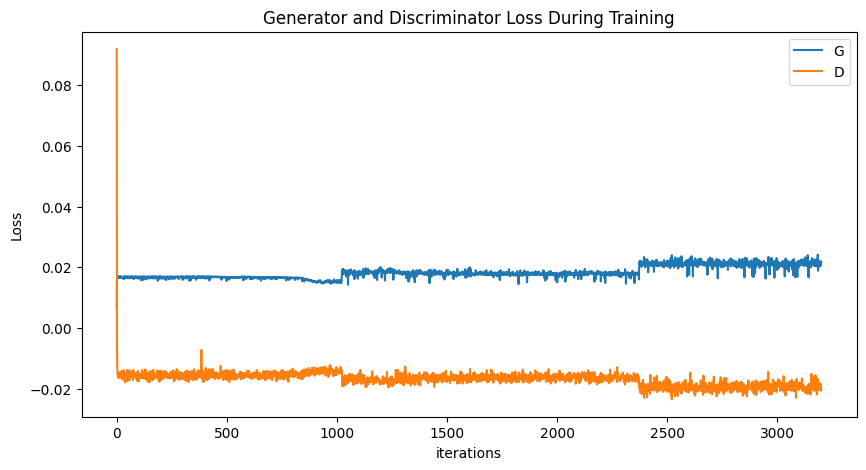

In [30]:
# 学習結果の可視化
import torchvision.utils as vutils
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()